# Models Creation

In [1]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
print(sys.version)

3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:51:40) 
[GCC 13.3.0]


In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras-nightly, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: 


In [4]:
import tensorflow as tf

2025-04-04 15:20:31.089244: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
# Listar GPUs disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Asegúrate de que la GPU 1 existe
        print("GPUs disponibles:")
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu}")

        # Limitar visibilidad a solo la GPU 1
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

        # Establecer límite de memoria a 40 GB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=40960)]
        )

        print("Configuración de GPU establecida correctamente.")
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("No se encontraron GPUs disponibles.")

GPUs disponibles:
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Configuración de GPU establecida correctamente.


2025-04-04 15:20:31.929029: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-04-04 15:20:31.971270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-04 15:20:31.972366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:ae:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-04 15:20:31.972386: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-04-04 15:20:31.975580: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.

In [6]:
# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d

In [7]:
train_df = pd.read_csv("../data/ml/train.csv")
valid_df = pd.read_csv("../data/ml/valid.csv")
test_df = pd.read_csv("../data/ml/test.csv")


In [8]:
#data = pd.read_csv("../data/ml/test.csv")

In [9]:
#data

In [10]:
"""# Dividir el dataset en train (80%), valid (10%), test (10%)
train_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['is_crime'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)"""

"# Dividir el dataset en train (80%), valid (10%), test (10%)\ntrain_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['is_crime'])\nvalid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)"

## Data Loader

In [11]:
class VideoDataModule:
    def __init__(self, train_df, val_df, test_df, batch_size=8, frame_size=(224, 224), num_frames=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.num_frames = num_frames
        tf.random.set_seed(42)  # Establecer la semilla

    def _load_video_frames(self, video_path, start_frame, end_frame, training=False):
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error: No se pudo abrir el video {video_path}")
            return None
        
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        start_frame = int(start_frame) if not np.isnan(start_frame) else 0
        end_frame = int(end_frame) if not np.isnan(end_frame) else total_frames
        
        step = max(1, (end_frame - start_frame) // self.num_frames)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.resize(frame, self.frame_size)  # Redimensionar
            frame = frame / 255.0  # Normalizar a [0,1]
            frame = tf.convert_to_tensor(frame, dtype=tf.float32)
            
            if training:
                frame = tf.image.random_flip_left_right(frame, seed=42)
                frame = tf.image.random_brightness(frame, max_delta=0.2, seed=42)
                frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2, seed=42)
                frame = tf.image.random_hue(frame, max_delta=0.05, seed=42)
                
            frames.append(frame.numpy())
            
            for _ in range(step - 1):  # Saltar frames para ajustarse al total
                cap.read()

        cap.release()

        while len(frames) < self.num_frames:
            frames.append(np.zeros((*self.frame_size, 3)))

        return np.array(frames, dtype=np.float32)

    def _dataframe_to_tf_dataset(self, df, shuffle=True, training=False):
        file_paths = df["Path"].values
        start_frames = df["PCB"].values
        end_frames = df["End_Frame"].values
        labels = df["is_crime"].values

        def generator():
            for i in range(len(file_paths)):
                video_tensor = self._load_video_frames(file_paths[i], start_frames[i], end_frames[i], training)
                yield video_tensor, labels[i]

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.num_frames, *self.frame_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
            ),
        )

        if shuffle:
            dataset = dataset.shuffle(
                buffer_size=min(max(1000, len(df)//10), len(df)),  
                seed=42,  
                reshuffle_each_iteration=True  
            )

        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    def train_dataset(self):
        return self._dataframe_to_tf_dataset(self.train_df, shuffle=True, training=True)

    def val_dataset(self):
        return self._dataframe_to_tf_dataset(self.val_df, shuffle=False, training=False)

    def test_dataset(self):
        return self._dataframe_to_tf_dataset(self.test_df, shuffle=False, training=False)

## I3D Model

In [12]:
# Clase adaptadora para usar InceptionI3D como modelo de Keras
class KerasI3D(tf.keras.Model):
    def __init__(self, num_classes, endpoint = "Logits"):
        super(KerasI3D, self).__init__()
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)

    def call(self, inputs, training=False):
        logits, _ = self.i3d(inputs)  # El modelo I3D devuelve logits y endpoints
        return logits

In [13]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

2025-04-04 15:20:32.094540: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-04 15:20:32.101176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:ae:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-04-04 15:20:32.103052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2025-04-04 15:20:32.103104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-04-04 15:20:32.832127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnec

### Learning rate Finder

In [14]:
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, start_lr=1e-7, end_lr=1, num_it=100):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_it = num_it
        self.lrs = []
        self.losses = []

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get("loss", None)
        if loss is not None:
            lr = self.start_lr * (self.end_lr / self.start_lr) ** (len(self.lrs) / self.num_it)
            self.lrs.append(lr)
            self.losses.append(loss)
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)

    def find_lr(self):
        """Encuentra el min_lr y el max_lr a partir de la curva de pérdida."""
        losses = np.array(self.losses)
        lrs = np.array(self.lrs)

        # Suavizar la pérdida con un filtro de media móvil para evitar ruido
        smoothed_losses = np.convolve(losses, np.ones(5) / 5, mode="valid")

        # Encontrar el índice con la pérdida mínima
        min_loss_idx = np.argmin(smoothed_losses)
        min_lr = lrs[min_loss_idx]

        # Encontrar el índice donde la pérdida aumenta abruptamente
        max_loss_grad_idx = np.argmax(np.gradient(smoothed_losses))
        max_lr = lrs[max_loss_grad_idx]

        return min_lr, max_lr

### Modelo

In [15]:
epochs = 5  # Número de épocas
initial_learning_rate = 1e-5
num_classes = 2

In [16]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

model_1 = KerasI3D(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_1.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [17]:
# Aplicar LR Finder en entrenamiento corto
lr_finder = LRFinder(start_lr=1e-7, end_lr=10, num_it=100)

model_1.fit(train_dataset, epochs=1, steps_per_epoch=100, callbacks=[lr_finder])

2025-04-04 15:20:39.935452: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2025-04-04 15:20:42.270333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-04-04 15:20:42.298265: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2025-04-04 15:20:59.037132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-04 15:21:08.954054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516
2025-04-04 15:21:19.017949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-04 15:21:29.076241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle bu

100/100 [==============================] - 191s 189ms/step - loss: 0.8283 - accuracy: 0.5756


In [18]:
# Obtener los valores óptimos de min_lr y max_lr
min_lr, max_lr = lr_finder.find_lr()
print(f"Min LR: {min_lr}, Max LR: {max_lr}")

Min LR: 2.5118864315095795e-05, Max LR: 0.001445439770745928


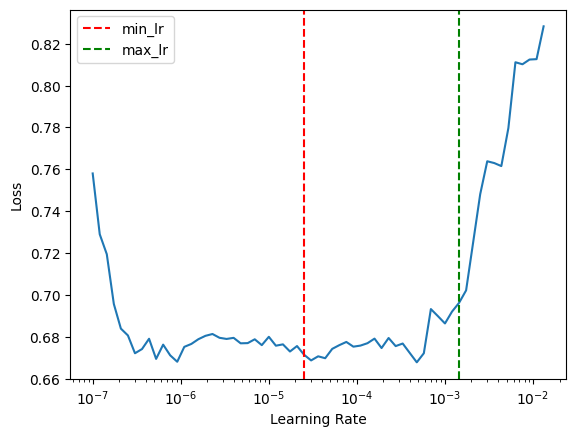

In [19]:
# Graficar la pérdida vs. learning rate
import matplotlib.pyplot as plt

# Suponiendo que max_lr y min_lr ya están definidos
plt.plot(lr_finder.lrs, lr_finder.losses)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")

# Agregar líneas verticales para max_lr y min_lr
plt.axvline(x=min_lr, color='r', linestyle='--', label="min_lr")
plt.axvline(x=max_lr, color='g', linestyle='--', label="max_lr")

# Agregar leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

### One Cycle Policy

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [21]:
print(f"Min LR: {min_lr}, Max LR: {max_lr}")

Min LR: 2.5118864315095795e-05, Max LR: 0.001445439770745928


In [22]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

In [23]:
checkpoint_dir = "checkpoints/i3d_model"
os.makedirs(checkpoint_dir, exist_ok=True)

last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
history_file = os.path.join(checkpoint_dir, "history.npy")

# Callback para guardar TODAS las épocas
full_history_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}"),
    save_freq='epoch',
    save_weights_only=True
)

# Callback para guardar solo el MEJOR modelo
best_model_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    monitor="val_loss",
    mode="min",
    save_best_only=True
)

# Intentar cargar la última época guardada
if os.path.exists(last_epoch_file):
    initial_epoch = int(np.load(last_epoch_file))
    model_1.load_weights(os.path.join(checkpoint_dir, "best_model"))
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0
    print("Starting training from scratch.")

# Callback para detener el entrenamiento si no hay mejora
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    mode="min", 
    restore_best_weights=True
)

# Callback para guardar el mejor modelo
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
)

lr_scheduler = LearningRateScheduler(one_cycle_scheduler)

# Callback para guardar la época actual
class EpochSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        np.save(last_epoch_file, epoch + 1)  # Guardar la siguiente época a entrenar

epoch_saver_callback = EpochSaver()

# Callback para guardar historial después de cada época
class HistorySaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            history_full['loss'].append(logs.get('loss', None))
            history_full['val_loss'].append(logs.get('val_loss', None))
            np.save(history_file, history_full)  # Guardar historial actualizado

history_saver_callback = HistorySaver()

# Cargar historial previo si existe
if os.path.exists(history_file):
    history_full = np.load(history_file, allow_pickle=True).item()
else:
    history_full = {'loss': [], 'val_loss': []}

# Verificar si el entrenamiento ya ha terminado
if initial_epoch >= epochs:
    print("Training already completed. No new epochs to run.")
else:
    # Entrenar desde la última época
    history = model_1.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[
            early_stop_callback, 
            checkpoint_callback, 
            lr_scheduler, 
            epoch_saver_callback, 
            full_history_callback, 
            best_model_callback,
            history_saver_callback  # Nuevo callback para guardar historial
        ],
        verbose=1
    )

Starting training from scratch.
Epoch 1/5


2025-04-04 15:23:55.147967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-04 15:24:05.263664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516
2025-04-04 15:24:15.190524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-04 15:24:25.313524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 145 of 516
2025-04-04 15:24:35.179697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 176 of 516
2025-04-04 15:24:45.137174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 211 of 516
2025-04-04 15:24:55.287970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

      6/Unknown - 154s 266ms/step - loss: 0.9792 - accuracy: 0.6250WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1314s vs `on_train_batch_end` time: 0.1326s). Check your callbacks.
65/65 [==============================] - 192s 616ms/step - loss: 1.1697 - accuracy: 0.4845 - val_loss: 1.0180 - val_accuracy: 0.5846
INFO:tensorflow:Assets written to: checkpoints/i3d_model/best_model/assets
Epoch 2/5


2025-04-04 15:27:27.768793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-04 15:27:37.693652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 80 of 516
2025-04-04 15:27:47.646061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 117 of 516
2025-04-04 15:27:57.652752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 146 of 516
2025-04-04 15:28:08.031322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-04 15:28:17.805308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 212 of 516
2025-04-04 15:28:27.658069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 188s 541ms/step - loss: 1.0369 - accuracy: 0.5039 - val_loss: 0.8715 - val_accuracy: 0.5692
INFO:tensorflow:Assets written to: checkpoints/i3d_model/best_model/assets
Epoch 3/5


2025-04-04 15:30:55.928331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-04 15:31:06.144727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516
2025-04-04 15:31:16.351920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-04 15:31:25.885069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 149 of 516
2025-04-04 15:31:36.056046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-04 15:31:46.117850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-04 15:31:56.113935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 187s 543ms/step - loss: 0.9007 - accuracy: 0.5388 - val_loss: 0.7443 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: checkpoints/i3d_model/best_model/assets
Epoch 4/5


2025-04-04 15:34:22.461269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-04 15:34:32.847469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516
2025-04-04 15:34:42.507211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-04 15:34:52.803857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-04 15:35:02.913214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-04 15:35:12.647456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-04 15:35:22.496026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 187s 549ms/step - loss: 0.7639 - accuracy: 0.5233 - val_loss: 0.6962 - val_accuracy: 0.6308
INFO:tensorflow:Assets written to: checkpoints/i3d_model/best_model/assets
Epoch 5/5


2025-04-04 15:37:49.271567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-04 15:37:59.187982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516
2025-04-04 15:38:09.268975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-04 15:38:19.189513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 144 of 516
2025-04-04 15:38:29.111406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-04 15:38:39.311365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-04 15:38:49.069724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 191s 552ms/step - loss: 0.7280 - accuracy: 0.4981 - val_loss: 0.6827 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: checkpoints/i3d_model/best_model/assets


In [24]:
history_full

{'loss': [1.1696573495864868,
  1.03693687915802,
  0.900719940662384,
  0.763933539390564,
  0.7279525399208069],
 'val_loss': [1.0180258750915527,
  0.871477484703064,
  0.7442764043807983,
  0.6961528062820435,
  0.6827242970466614]}

### Evolución del Learning rate

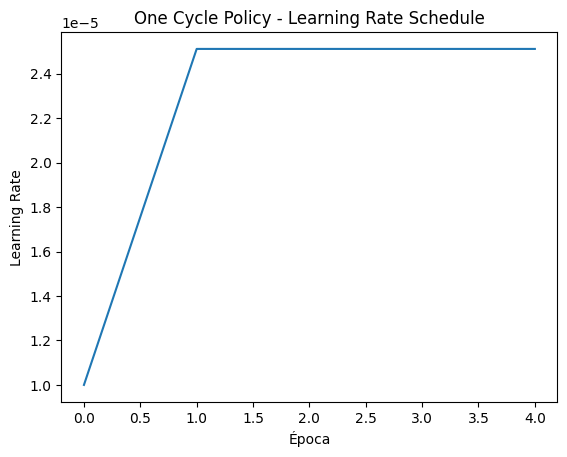

In [25]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

In [26]:
train_results = model_1.evaluate(train_dataset, verbose=1)

2025-04-04 15:41:21.947641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-04 15:41:31.998014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516
2025-04-04 15:41:42.059648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-04 15:41:52.114862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 145 of 516
2025-04-04 15:42:01.976679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 176 of 516
2025-04-04 15:42:12.000319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 212 of 516
2025-04-04 15:42:22.019094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 162s 128ms/step - loss: 0.7001 - accuracy: 0.5213


In [27]:
# Evaluar en el conjunto de validación
val_results = model_1.evaluate(val_dataset, verbose=1)

9/9 [==============================] - 18s 2s/step - loss: 0.6827 - accuracy: 0.6154


In [28]:
# Evaluar en el conjunto de prueba
test_results = model_1.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 20s 2s/step - loss: 0.6948 - accuracy: 0.5692


In [29]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.7001208662986755, Accuracy: 0.5213178396224976
Val - Loss: 0.6827242970466614, Accuracy: 0.6153846383094788
Test - Loss: 0.6947879791259766, Accuracy: 0.5692307949066162


### Gráfica Epochs vs Loss

In [30]:
history_full

{'loss': [1.1696573495864868,
  1.03693687915802,
  0.900719940662384,
  0.763933539390564,
  0.7279525399208069],
 'val_loss': [1.0180258750915527,
  0.871477484703064,
  0.7442764043807983,
  0.6961528062820435,
  0.6827242970466614]}

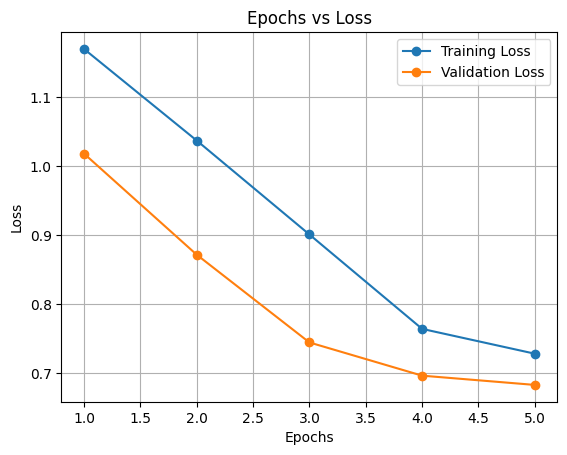

In [31]:
import matplotlib.pyplot as plt
# Extraer la pérdida de entrenamiento y validación
loss = history_full['loss']
val_loss = history_full['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 65, Usando perplexity=10


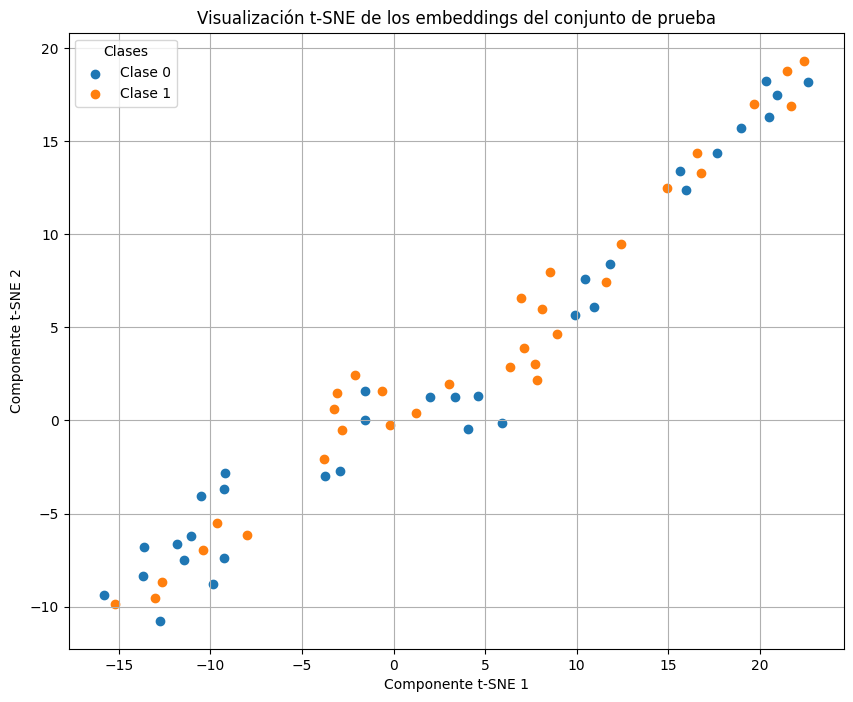

In [32]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_1.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## I3D + ConvLSTM2D

In [33]:
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, Dense, 
                                    Flatten, GlobalAveragePooling2D, 
                                    Dropout, BatchNormalization)
from tensorflow.keras import Model

class I3D_ConvLSTM(Model):
    def __init__(self, num_classes, endpoint="Mixed_5c"):
        super(I3D_ConvLSTM, self).__init__()
        
        # Modelo base Inception I3D
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
        
        # Capa ConvLSTM2D para modelar información temporal
        self.conv_lstm = ConvLSTM2D(
            filters=64, 
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True,  # Mantener la dimensión temporal
            dropout=0.2,
            recurrent_dropout=0.2
        )
        
        # Batch Normalization después de ConvLSTM
        self.batch_norm = BatchNormalization()
        
        # Global Average Pooling para reducir dimensionalidad
        self.global_avg_pool = GlobalAveragePooling2D()  # Cambio a 2D
        
        # Dropout para regularización
        self.dropout = Dropout(0.3)
        
        # Capa completamente conectada final
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        """Entrada esperada: (batch_size, num_frames, height, width, channels)"""
        
        # Extraer características con I3D
        features, _ = self.i3d(inputs)  # (batch_size, num_frames, 7, 7, 1024)
        
        # Aplicar ConvLSTM2D sobre la dimensión temporal
        lstm_out = self.conv_lstm(features)  # (batch_size, num_frames, 7, 7, 64)
        
        # Tomar solo el último frame de la salida de LSTM para clasificación
        lstm_out = lstm_out[:, -1, :, :, :]  # (batch_size, 7, 7, 64)

        # Batch Normalization
        x = self.batch_norm(lstm_out, training=training)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Dropout para regularización
        x = self.dropout(x, training=training)
        
        # Capa de salida
        logits = self.fc(x)
        
        return logits

In [34]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

### Modelo

In [35]:
epochs = 5  # Número de épocas
initial_learning_rate = 1e-30  # Ejemplo
num_classes = 2

In [36]:
model_2 = I3D_ConvLSTM(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_2.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [37]:
# Aplicar LR Finder en entrenamiento corto
lr_finder = LRFinder(start_lr=1e-30, end_lr=1e-15, num_it=100)

model_2.fit(train_dataset, epochs=1, steps_per_epoch=100, callbacks=[lr_finder])

/home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2025-04-04 15:45:42.374199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-04 15:45:52.706300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516
2025-04-04 15:46:02.366563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 120 of 516
2025-04-04 15:46:12.401050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-04 15:46:22.624552: I tensorflow/core/kernels/data/shuffle_datase

100/100 [==============================] - 186s 180ms/step - loss: 0.7820 - accuracy: 0.4593


In [38]:
# Obtener los valores óptimos de min_lr y max_lr
min_lr, max_lr = lr_finder.find_lr()
print(f"Min LR: {min_lr}, Max LR: {max_lr}")

Min LR: 1.4125375446227545e-30, Max LR: 1.1220184543019637e-29


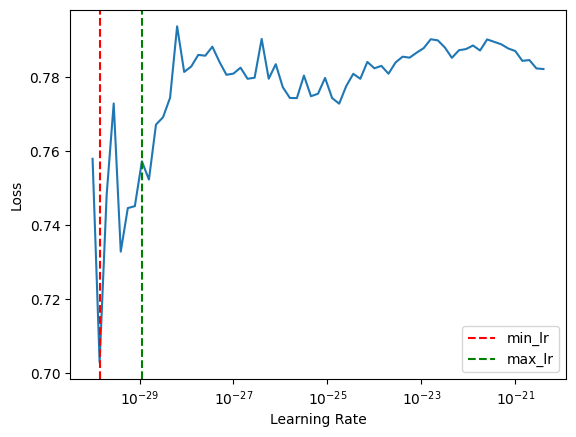

In [39]:
# Graficar la pérdida vs. learning rate
import matplotlib.pyplot as plt

# Suponiendo que max_lr y min_lr ya están definidos
plt.plot(lr_finder.lrs, lr_finder.losses)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")

# Agregar líneas verticales para max_lr y min_lr
plt.axvline(x=min_lr, color='r', linestyle='--', label="min_lr")
plt.axvline(x=max_lr, color='g', linestyle='--', label="max_lr")

# Agregar leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [41]:
max_lr = max_lr * 10
print(f"Min LR: {min_lr}, Max LR: {max_lr}")

Min LR: 1.4125375446227545e-30, Max LR: 1.1220184543019638e-28


In [42]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

In [43]:
checkpoint_dir = "checkpoints/i3dLstm_model"
os.makedirs(checkpoint_dir, exist_ok=True)

last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
history_file = os.path.join(checkpoint_dir, "history.npy")

# Callback para guardar TODAS las épocas
full_history_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}"),
    save_freq='epoch',
    save_weights_only=True
)

# Callback para guardar solo el MEJOR modelo
best_model_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    monitor="val_loss",
    mode="min",
    save_best_only=True
)

# Intentar cargar la última época guardada
if os.path.exists(last_epoch_file):
    initial_epoch = int(np.load(last_epoch_file))
    model_2.load_weights(os.path.join(checkpoint_dir, "best_model"))
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0
    print("Starting training from scratch.")

# Callback para detener el entrenamiento si no hay mejora
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    mode="min", 
    restore_best_weights=True
)

# Callback para guardar el mejor modelo
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
)

lr_scheduler = LearningRateScheduler(one_cycle_scheduler)

# Callback para guardar la época actual
class EpochSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        np.save(last_epoch_file, epoch + 1)  # Guardar la siguiente época a entrenar

epoch_saver_callback = EpochSaver()

# Callback para guardar historial después de cada época
class HistorySaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            history_full['loss'].append(logs.get('loss', None))
            history_full['val_loss'].append(logs.get('val_loss', None))
            np.save(history_file, history_full)  # Guardar historial actualizado

history_saver_callback = HistorySaver()

# Cargar historial previo si existe
if os.path.exists(history_file):
    history_full = np.load(history_file, allow_pickle=True).item()
else:
    history_full = {'loss': [], 'val_loss': []}

# Verificar si el entrenamiento ya ha terminado
if initial_epoch >= epochs:
    print("Training already completed. No new epochs to run.")
else:
    # Entrenar desde la última época
    history = model_2.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[
            early_stop_callback, 
            checkpoint_callback, 
            lr_scheduler, 
            epoch_saver_callback, 
            full_history_callback, 
            best_model_callback,
            history_saver_callback  # Nuevo callback para guardar historial
        ],
        verbose=1
    )

Starting training from scratch.
Epoch 1/5


2025-04-04 15:48:32.417008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-04 15:48:42.610244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516
2025-04-04 15:48:52.319371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 120 of 516
2025-04-04 15:49:02.642537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-04 15:49:12.295288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-04 15:49:22.379305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 213 of 516
2025-04-04 15:49:32.542375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 192s 606ms/step - loss: 0.7699 - accuracy: 0.4535 - val_loss: 0.7417 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: checkpoints/i3dLstm_model/best_model/assets
Epoch 2/5


2025-04-04 15:52:07.128514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-04 15:52:17.098802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 80 of 516
2025-04-04 15:52:27.038464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-04 15:52:37.058023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 146 of 516
2025-04-04 15:52:47.207048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-04 15:52:57.524267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-04 15:53:07.478140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 188s 560ms/step - loss: 0.7785 - accuracy: 0.4554 - val_loss: 0.7573 - val_accuracy: 0.3846
Epoch 3/5


2025-04-04 15:55:16.795192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-04 15:55:27.110885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516
2025-04-04 15:55:36.608237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-04 15:55:46.698019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-04 15:55:56.845039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-04 15:56:06.845719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-04 15:56:17.020358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 188s 557ms/step - loss: 0.7790 - accuracy: 0.4787 - val_loss: 0.7743 - val_accuracy: 0.3692
Epoch 4/5


2025-04-04 15:58:26.776017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-04 15:58:36.707764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516
2025-04-04 15:58:46.651554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 117 of 516
2025-04-04 15:58:56.676008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 146 of 516
2025-04-04 15:59:06.923285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-04 15:59:16.776036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 213 of 516
2025-04-04 15:59:26.660744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 189s 561ms/step - loss: 0.7505 - accuracy: 0.5000 - val_loss: 0.7902 - val_accuracy: 0.3538


In [44]:
train_results = model_2.evaluate(train_dataset, verbose=1)

2025-04-04 16:01:37.358138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-04 16:01:47.312678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516
2025-04-04 16:01:57.303793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-04 16:02:07.456216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-04 16:02:17.596553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-04 16:02:27.476922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-04 16:02:37.331550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 159s 121ms/step - loss: 0.7205 - accuracy: 0.4360


In [45]:
# Evaluar en el conjunto de validación
val_results = model_2.evaluate(val_dataset, verbose=1)

9/9 [==============================] - 18s 2s/step - loss: 0.7417 - accuracy: 0.3846


In [46]:
# Evaluar en el conjunto de prueba
test_results = model_2.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 19s 2s/step - loss: 0.6939 - accuracy: 0.6000


In [47]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.7205252647399902, Accuracy: 0.4360465109348297
Val - Loss: 0.7416509985923767, Accuracy: 0.38461539149284363
Test - Loss: 0.6939252614974976, Accuracy: 0.6000000238418579


### Evolución del Learning rate

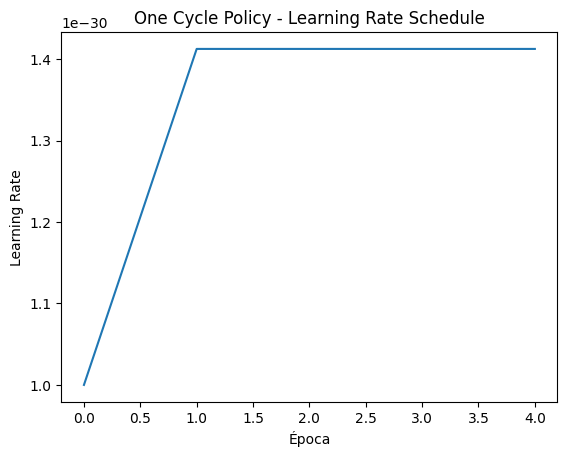

In [48]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

### Gráfica Epochs vs Loss

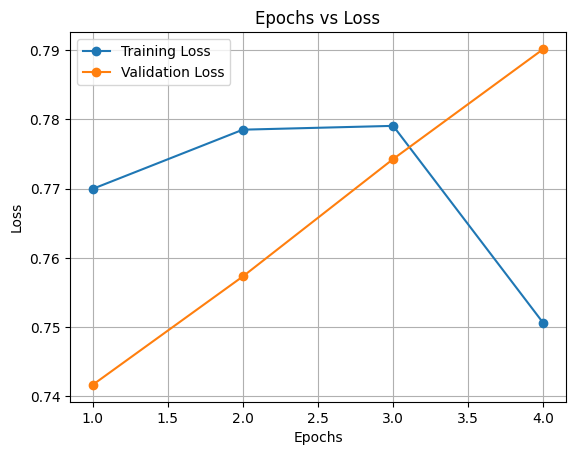

In [49]:
import matplotlib.pyplot as plt

# Extraer la pérdida de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 65, Usando perplexity=10


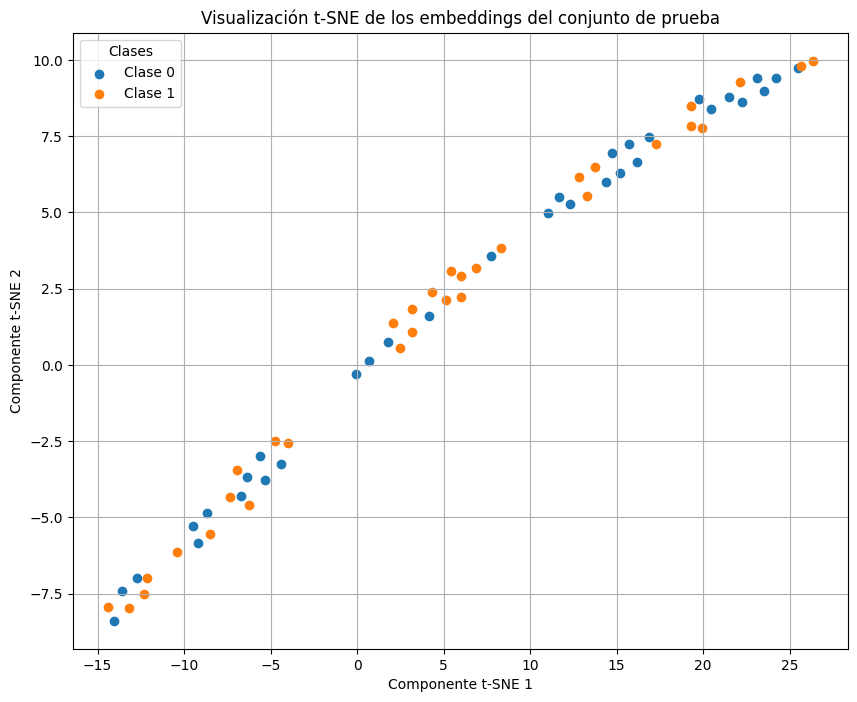

In [50]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_2.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## Comparación de modelos

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
print('---------------------------------------------')
print("Modelo I3D")
# Obtener predicciones en el conjunto de prueba
y_pred = model_1.predict(test_dataset).argmax(axis=1)

# Obtener etiquetas reales del conjunto de prueba
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Convertir a numpy si es un tensor

# Imprimir el reporte de clasificación
print("Classification Report:\n", classification_report(y_true, y_pred))

# Imprimir la matriz de confusión
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

print('---------------------------------------------')
print("Modelo I3D+ConvLSTM")

# Obtener predicciones en el conjunto de prueba
y_pred = model_2.predict(test_dataset).argmax(axis=1)

# Obtener etiquetas reales del conjunto de prueba
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Convertir a numpy si es un tensor

# Imprimir el reporte de clasificación
print("Classification Report:\n", classification_report(y_true, y_pred))

# Imprimir la matriz de confusión
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

---------------------------------------------
Modelo I3D
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.52      0.55        33
           1       0.56      0.62      0.59        32

    accuracy                           0.57        65
   macro avg       0.57      0.57      0.57        65
weighted avg       0.57      0.57      0.57        65

Confusion Matrix:
 [[17 16]
 [12 20]]
---------------------------------------------
Modelo I3D+ConvLSTM
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.52      0.57        33
           1       0.58      0.69      0.63        32

    accuracy                           0.60        65
   macro avg       0.60      0.60      0.60        65
weighted avg       0.60      0.60      0.60        65

Confusion Matrix:
 [[17 16]
 [10 22]]
